In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Gymnasium and ALE
import gymnasium as gym
import ale_py

# Stable Baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback

# Wandb Integration
import wandb
from wandb.integration.sb3 import WandbCallback

# Custom constants
import ppo_pacman_constants as constants

C:\Users\propietari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_env(env_id, render_mode=None):
    def _env():
        env = gym.make(env_id, render_mode=render_mode)
        env = Monitor(env, allow_early_resets=True)  
        return env
    return _env

In [3]:
def test_model(model, env, n_episodes=100):
    gif_folder = "videos_trained_agent"
    os.makedirs(gif_folder, exist_ok=True)

    rewards_per_episode = []
    episode_lengths = []

    # Run test episodes
    for episode in range(n_episodes):
        obs = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        images = []

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward[0]  # reward is in list format
            episode_length += 1

            img = env.render()
            images.append(Image.fromarray(img))

        rewards_per_episode.append(episode_reward)
        episode_lengths.append(episode_length)
        print(f"Episode {episode + 1}: Reward = {episode_reward}, Length = {episode_length}")

        if done:
            if (episode + 1) % 10 == 0:
                gif_filename = os.path.join(gif_folder, f"ppo_trained_agent_episode_{episode + 1}.gif")
                images[0].save(
                    gif_filename,
                    save_all=True,
                    append_images=images[1:],
                    duration=60,
                    loop=0,
                )
                print(f"Saved GIF for Episode {episode + 1} as {gif_filename}")

    # Print statistics
    print(f"Testing completed: {n_episodes} episodes")
    print(f"Mean reward: {np.mean(rewards_per_episode):.2f}")
    print(f"Std of rewards: {np.std(rewards_per_episode):.2f}")
    print(f"Max reward: {np.max(rewards_per_episode)}")
    print(f"Min reward: {np.min(rewards_per_episode)}")

    # Return metrics for further analysis
    return rewards_per_episode, episode_lengths

Testing...
Episode 1: Reward = 342.0, Length = 670
Episode 2: Reward = 345.0, Length = 596
Episode 3: Reward = 345.0, Length = 614
Episode 4: Reward = 348.0, Length = 620
Episode 5: Reward = 360.0, Length = 750
Episode 6: Reward = 367.0, Length = 934
Episode 7: Reward = 346.0, Length = 672
Episode 8: Reward = 343.0, Length = 580
Episode 9: Reward = 358.0, Length = 856
Episode 10: Reward = 126.0, Length = 748
Saved GIF for Episode 10 as videos_trained_agent\ppo_trained_agent_episode_10.gif
Episode 11: Reward = 342.0, Length = 582
Episode 12: Reward = 348.0, Length = 624
Episode 13: Reward = 347.0, Length = 684
Episode 14: Reward = 187.0, Length = 710
Episode 15: Reward = 359.0, Length = 906
Episode 16: Reward = 185.0, Length = 584
Episode 17: Reward = 367.0, Length = 826
Episode 18: Reward = 355.0, Length = 738
Episode 19: Reward = 346.0, Length = 724
Episode 20: Reward = 355.0, Length = 770
Saved GIF for Episode 20 as videos_trained_agent\ppo_trained_agent_episode_20.gif
Episode 21: Re

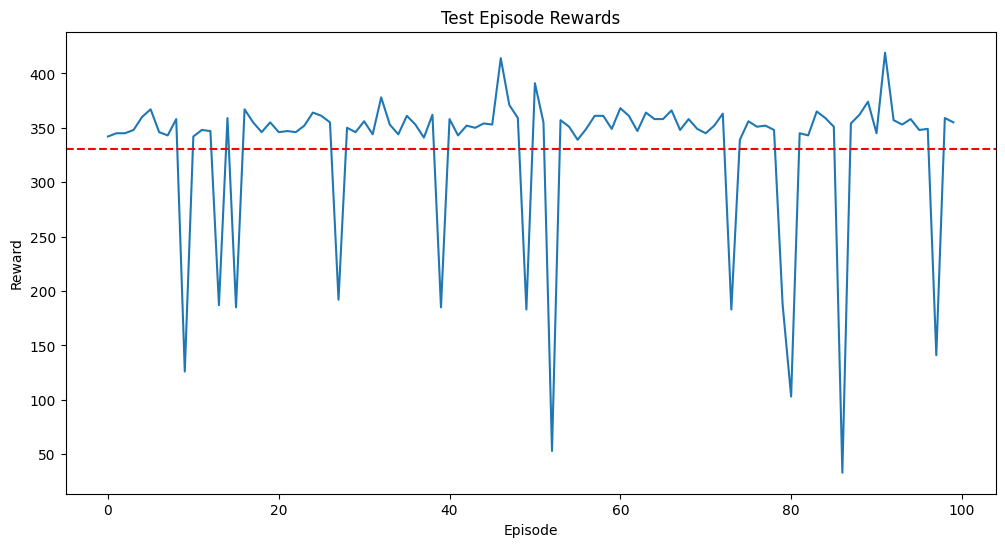

In [6]:
# Load the trained PPO model
model_path = r"logs\ppo_best_model.zip"

model = PPO.load(model_path)

env_id = "ALE/Pacman-v5"  
test_env = DummyVecEnv([make_env(env_id, render_mode='rgb_array') for i in range(1)])  

# Test the model
print("Testing...")
rewards_per_episode, episode_lengths = test_model(model, test_env, n_episodes=100)

# Plot results: Reward per episode
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode)
plt.axhline(np.mean(rewards_per_episode), color='red', linestyle='--', label='Mean Reward')
plt.title("Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

test_env.close()

